In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Data_sets/complete_flow/

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,date,timedelta
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from google.colab import files
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import glob
import os

# below are the functions and the components of the complete flow
def get_data_from_drive(path):

  """
    Get csv file from given file path.

    Args:
        path (str): Location for the file.

    Returns:
        data (pd.DataFrame): A DataFrame Object of given file path.
    """

  data = pd.read_csv(path)
  return data

"""
    Removal of records with error records.
    Remove data with zero values for longitude and latitude columns.
    Sort data by time and device.

    Args:
        raw_data (pd.DataFrame): Crude raw GPS data filtered out from the server for the required time window.

    Returns:
        gps_data (pd.DataFrame): A cleaned dataframe object of GPS data.
    """
class Cleaner( BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    gps_data = X[X.latitude != 0]
    gps_data = gps_data[gps_data.longitude != 0] #cleaning zero values for latitude & longitude

    gps_data['date'] = pd.to_datetime(gps_data['devicetime']).dt.date #split date and time separately into datetime variables
    gps_data['time'] = pd.to_datetime(gps_data['devicetime']).dt.time

    gps_data = gps_data.sort_values(['deviceid', 'date', 'time']) #sorting dataset by time and device

    return gps_data


class Dropper( BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    additional_columns = ['servertime','fixtime','address','routeid']
    return X.drop(additional_columns, axis=1)

def download_csv(data,filename):

  """
    To download output as CSV files

    Args:
        data (pd.DataFrame): DataFrame Object.
        filename (str): Name of the file has to be faved.

    Returns:
        None
  """

  filename= filename + '.csv'
  data.to_csv(filename, encoding = 'utf-8-sig',index= False)
  files.download(filename)


def trip_ends_extraction(gps_data,bus_terminals,end_buffer):

  """
    To extract trip ends dataframe with given buffer range.
    Filter the records within terminals selected buffer range.
    Within the filtered records get entry & exit to terminals.


    Args:
        gps_data (pd.DataFrame): Cleaned gps data filtered out from the server for the required time window.
        bus_terminals (pd.DataFrame): End and start terminals for the trip.
        end_buffer (int):  Radius of the buffer area to represent terminals.

    Returns:
        trip_ends (pd.DataFrame): Trip data with extracted terminals.
  """

  #converting to GeoDataframe with Coordinate Reference system 4326
  gps_data = gpd.GeoDataFrame(gps_data, geometry=gpd.points_from_xy(gps_data.longitude,gps_data.latitude),crs='EPSG:4326')
  bus_terminals = gpd.GeoDataFrame(bus_terminals, geometry=gpd.points_from_xy(bus_terminals.longitude,bus_terminals.latitude),crs='EPSG:4326')

  #project them in local cordinate system
  gps_data = gps_data.to_crs('EPSG:5234')
  bus_terminals = bus_terminals.to_crs('EPSG:5234')

  #creating buffer area to extract records around bus terminals
  bus_terminals_buffer = gpd.GeoDataFrame(bus_terminals, geometry = bus_terminals.geometry.buffer(end_buffer))

  #filtering coordinates within bus terminals end buffer
  gps_data['bus_stop'] = pd.Series(dtype='object') #create a new column in gps data set
  gps_data.reset_index(drop = True, inplace = True) #reset indices to run a for loop

  for i in range(len(gps_data)):
    for stop in range(len(bus_terminals)):
      if bus_terminals_buffer.iloc[stop].geometry.contains(gps_data.iloc[i].geometry):
        gps_data.at[i,'bus_stop'] = bus_terminals.at[stop,'terminal_id']

  trip_ends = gps_data.dropna() #filter records within terminal buffer

  #EXTRACT TRIP ENDS

  #grouping the filtered records of one bus terminal and one date
  trip_ends['grouped_ends'] = ((trip_ends['bus_stop'].shift() != trip_ends['bus_stop']) | (trip_ends['date'].shift() != trip_ends['date'])).cumsum()

  #find the entry or exit record only of the terminals
  #Early records is the entry(1) to the terminal and last record as the exit(0) to the end terminal
  trip_ends['entry/exit'] = pd.Series(dtype='object')
  trip_ends = trip_ends.reset_index(drop=True)

  for name, group in trip_ends.groupby('grouped_ends'):
    #if 0 in group['speed'].values:
    for index, row in group.iterrows():
      if row['devicetime'] == group['devicetime'].max():
        trip_ends.at[index,'entry/exit'] = '0'
      elif row['devicetime'] == group['devicetime'].min():
        trip_ends.at[index,'entry/exit'] = '1'

  trip_ends = trip_ends.dropna() #filter terminal entry/exit records only

  trip_ends = trip_ends.reset_index(drop=True)

  #Providing unique trip id for trips which have entry / exit values within the 2 bus end terminals
  trip = 0
  for i in range(len(trip_ends)-1):
    if (trip_ends.at[i,'bus_stop'] != trip_ends.at[i+1,'bus_stop']) & (trip_ends.at[i,'date'] == trip_ends.at[i+1,'date']):
      trip= trip+1
      trip_ends.at[i,'trip_id'] = trip
      trip_ends.at[i+1,'trip_id'] = trip

  trip_ends = trip_ends.dropna()

  trip_ends = trip_ends.groupby('trip_id').filter(lambda x : len(x)>1)    #remove outliers where no defined 2 trip ends for a trip
  trip_ends = trip_ends.reset_index(drop=True)

  return trip_ends

def trip_extraction(trip_ends):

  """
    To extract bus trips with derived columns.
    Create end_time, end_terminal for a bus trip.
    Create features of duration, duration_in_mins, day_of_the_week, hour_of_day

    Args:
        trip_ends (pd.DataFrame): Filtered bus trip data with terminals.

    Returns:
        bus_trips (pd.DataFrame): Bus trip terminals data with derived features.
  """

  bus_trips = trip_ends.copy()
  bus_trips[['end_time','end_terminal']] = bus_trips[['time','bus_stop']].shift(-1)
  bus_trips = bus_trips.iloc[::2]

  bus_trips = bus_trips.drop(['id','devicetime','latitude','longitude','speed','geometry','grouped_ends','entry/exit'],axis=1)
  bus_trips.insert(0,'trip_id',bus_trips.pop('trip_id'))
  bus_trips.rename(columns = {'time':'start_time','bus_stop': 'start_terminal'}, inplace =True)

  conditions = [(bus_trips['start_terminal'] == 'BT01'),
              (bus_trips['start_terminal'] == 'BT02')]
  values = [1,2]

  bus_trips['direction'] = np.select(conditions, values)

  bus_trips = bus_trips[['trip_id','deviceid','date','start_terminal','end_terminal','direction','start_time','end_time']]
  bus_trips=bus_trips.reset_index(drop = True)

  #Calculate trip duration
  bus_trips['duration'] = pd.Series(dtype='object')
  for i in range(len(bus_trips)):
    bus_trips.at[i,'duration'] = datetime.combine(date.min,bus_trips.at[i,'end_time']) - datetime.combine(date.min,bus_trips.at[i,'start_time'])

  bus_trips['duration_in_mins'] = bus_trips['duration']/np.timedelta64(1,'m')

  bus_trips['day_of_week'] = pd.to_datetime(bus_trips['date']).dt.weekday
  bus_trips['hour_of_day'] = list(map(lambda  x: x.hour, (bus_trips['start_time'])))

  return bus_trips

# Add trip_ids for the gps data frame
def filter_all(gps_data,trip_ends):
  """

    To extract all correct data raw point
    from start point to ent point.
    Args:
        gps_data (pd.DataFrame): Cleaned gps data filtered out from the server for the required time window.
        trip_ends (pd.DataFrame): Filtered bus trip data with terminals.

    Returns:
      row_bus_data (pd.DataFrame): all correct data raw point from start point to ent point..
  """
  pointer = 0
  new_gps_data = []
  new_columns = ['id','deviceid','devicetime','latitude','longitude','speed','date','time','trip_id']
  index_num = 0
  for index,row in gps_data.iterrows():
    # print(index_num,":",row['deviceid'],":",pointer)
    if datetime.strptime(trip_ends.loc[pointer,'devicetime'], "%Y-%m-%d %H:%M:%S")<=datetime.strptime(row['devicetime'], "%Y-%m-%d %H:%M:%S")<=datetime.strptime(trip_ends.loc[pointer+1,'devicetime'], "%Y-%m-%d %H:%M:%S"):
      new_row = [row['id'],row['deviceid'],row['devicetime'],row['latitude'],row['longitude'],row['speed'],row['date'],row['time'],trip_ends.loc[pointer,'trip_id']]
      new_gps_data.append(new_row)
      # print(row['id'],":",row['id'] == trip_ends.loc[pointer+1,'id']," ",pointer+2)
      if row['id'] == trip_ends.loc[pointer+1,'id']:
        pointer+=2
        if(pointer == len(trip_ends)):
          break
        # print("pointer:",pointer+2)
        # print(trip_ends.loc[pointer,'id'])
    index_num+=1
  new_gps_data = pd.DataFrame(new_gps_data, columns=new_columns)
  return new_gps_data

class TripExtractor( BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    end_buffer = 100
    trip_ends = trip_ends_extraction(X,bus_terminals,end_buffer)
    bus_trips = trip_extraction(trip_ends)
    gps_data_2 =filter_all(X,trip_ends)
    return gps_data_2,bus_trips  # returns gps_data dataframe with trip ids, and bus_trips dataframe


class TripSegmenter( BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    gps_data_ts, bus_trips_ts = X
    new_records = []  # List to store the split records
    for index, row in bus_trips_ts.iterrows():
      duration = row['duration_in_mins']

      date_string = f"{row['date']} {row['start_time']}"
      format_string = "%Y-%m-%d %H:%M:%S"
      parsed_date = datetime.strptime(date_string, format_string)
      start_time = pd.Timestamp(parsed_date)

      # Generate a range of 3-minute intervals for the current record
      time_intervals = pd.date_range(start=start_time, periods=duration, freq='3T')

      # Iterate over the time intervals and create a new record for each interval
      for interval in time_intervals:
          end_time = interval + timedelta(minutes=3)
          new_record = {
              'segment_starting_time': pd.to_datetime(interval),
              'segment_ending_time': pd.to_datetime(end_time),
              'trip_id': row['trip_id'],
              'deviceid': row['deviceid'],
              'date': row['date'],
              'start_terminal':row['start_terminal'],
              'end_terminal': row['end_terminal'],
              'direction': row['direction'],
              'day_of_week': row['day_of_week'],
              'hour_of_day': row['hour_of_day']
          }
          new_records.append(new_record)

    # Create a new DataFrame from the split records
    segments_df = pd.DataFrame(new_records)
    segments_df['segment_id'] = [i for i in range(1,len(segments_df)+1)]

    # add the segment id to the GPS data
    segment_ids = []
    for index, row in gps_data_ts.iterrows():
      device_time = pd.to_datetime(row['devicetime'])
      device_id = row['deviceid']
      temp_df1 = segments_df[(segments_df["segment_starting_time"]<=device_time) & (segments_df["segment_ending_time"]>device_time)]
      temp_df2 = temp_df1[temp_df1["deviceid"]==device_id]
      if len(temp_df2)>0:
        segment_ids_temp = temp_df2['segment_id'].values
        segment_id = segment_ids_temp[0]
      else:
        segment_id= None
      segment_ids.append(segment_id)

    gps_data_ts["segment_id"] = segment_ids
    return gps_data_ts, segments_df


class CalculateFeatures( BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    gps_data_df, segments_df = X
    max_speeds = []
    speed_variences = []
    for index, row in segments_df.iterrows():
      segment_id = row["segment_id"]
      speeds = gps_data_df[gps_data_df["segment_id"]==segment_id]["speed"].values
      if len(speeds)>0:
        max_speed = max(speeds)
        variation = np.var(speeds)
      else:
        max_speed = None
        variation = None
      max_speeds.append(max_speed)
      speed_variences.append(variation)
    segments_df["max_speed"] = max_speeds
    segments_df["variation"] = speed_variences

    return gps_data_df, segments_df


class Standardizer( BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    scaler = StandardScaler()
    gps_data_df, segments_df = X

    segments_df = segments_df.dropna()
    segments_df["max_speed"] = scaler.fit_transform(segments_df[["max_speed"]])
    segments_df["variation"] = scaler.fit_transform(segments_df[["variation"]])
    segments_df["day_of_week"] = scaler.fit_transform(segments_df[["day_of_week"]])
    segments_df["hour_of_day"] = scaler.fit_transform(segments_df[["hour_of_day"]])
    return gps_data_df, segments_df


In [ ]:
path_raw_data = '/content/drive/MyDrive/Data_sets/Raw-GPS-data-Kandy-Buses/digana_2021_10.csv'
path_bus_terminals = '/content/drive/MyDrive/Data_sets/Raw-GPS-data-Kandy-Buses/more/bus_terminals_654.csv'

# load the raw data and the bus terminals
raw_data = get_data_from_drive(path_raw_data)
bus_terminals = get_data_from_drive(path_bus_terminals)

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("cleaner", Cleaner()),
    ("dropper", Dropper()),
    ("TripExtractor", TripExtractor()),
    ("TripSegmentor", TripSegmenter()),
    ("CalculateFeatures", CalculateFeatures()),
    ("Standardizer", Standardizer())
])
gps_data_p, bus_trips_p = pipe.fit_transform(raw_data)

In [ ]:
dropped_df = bus_trips_p.drop(["segment_starting_time","segment_ending_time","trip_id","deviceid","date","start_terminal","end_terminal","direction","segment_id","day_of_week","hour_of_day"],axis=1)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(dropped_df)
    wcss.append(kmeans.inertia_)

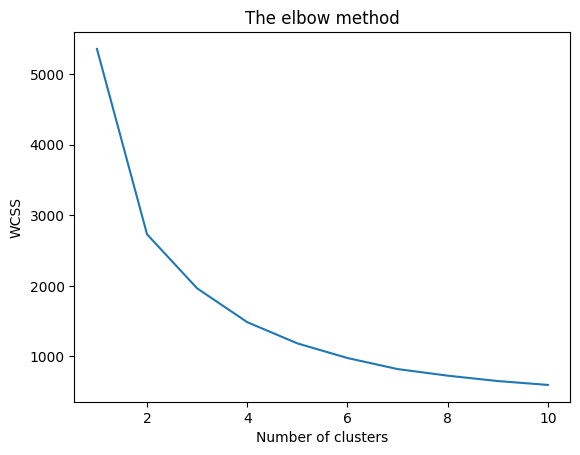

In [ ]:
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(dropped_df)

In [ ]:
bus_trips_p["labels"] = kmeans.labels_

In [ ]:
bus_trips_p

,segment_starting_time,segment_ending_time,trip_id,deviceid,date,start_terminal,end_terminal,direction,day_of_week,hour_of_day,segment_id,max_speed,variation,labels
0,2021-10-16 07:08:31,2021-10-16 07:11:31,1.0,116,2021-10-16,BT02,BT01,2,0.880155,-1.081452,1,1.708694,2.821877,1
1,2021-10-16 07:11:31,2021-10-16 07:14:31,1.0,116,2021-10-16,BT02,BT01,2,0.880155,-1.081452,2,3.356535,5.334294,1
2,2021-10-16 07:14:31,2021-10-16 07:17:31,1.0,116,2021-10-16,BT02,BT01,2,0.880155,-1.081452,3,1.514833,2.741430,1
3,2021-10-16 07:17:31,2021-10-16 07:20:31,1.0,116,2021-10-16,BT02,BT01,2,0.880155,-1.081452,4,-0.714590,-0.330957,2
4,2021-10-16 07:20:31,2021-10-16 07:23:31,1.0,116,2021-10-16,BT02,BT01,2,0.880155,-1.081452,5,-0.229930,-0.569459,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4420,2021-11-01 17:16:41,2021-11-01 17:19:41,84.0,116,2021-11-01,BT02,BT01,2,-1.509870,0.947479,4421,-3.040953,-1.582698,0
4437,2021-11-01 17:19:35,2021-11-01 17:22:35,85.0,116,2021-11-01,BT01,BT02,1,-1.509870,1.527174,4438,0.739373,1.895970,1
4438,2021-11-01 17:22:35,2021-11-01 17:25:35,85.0,116,2021-11-01,BT01,BT02,1,-1.509870,1.527174,4439,-0.229930,-0.517725,0
4439,2021-11-01 17:25:35,2021-11-01 17:28:35,85.0,116,2021-11-01,BT01,BT02,1,-1.509870,1.527174,4440,0.157791,0.392770,0


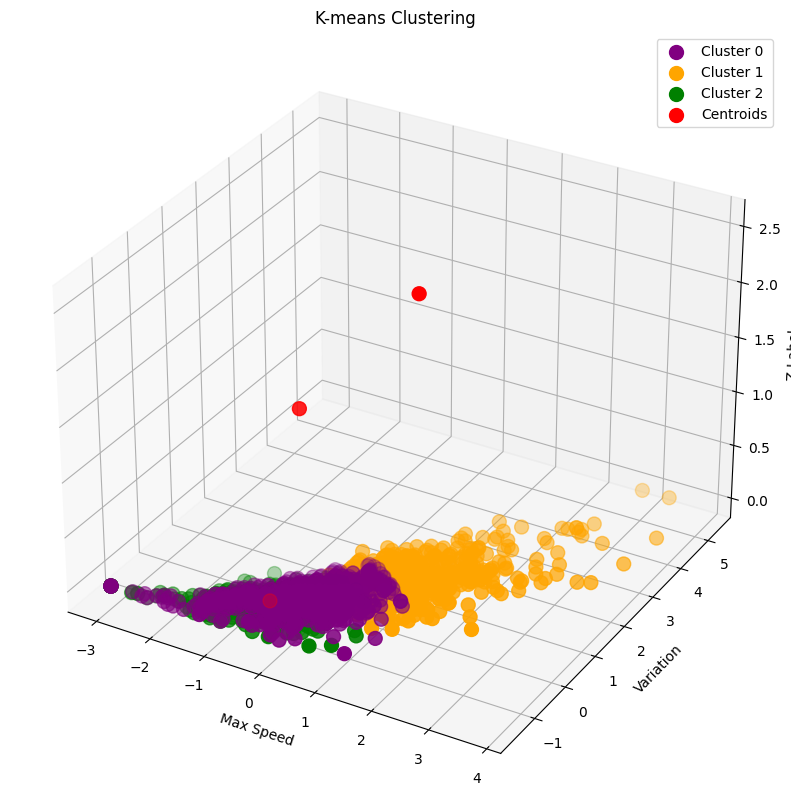

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots for each cluster
ax.scatter(bus_trips_p.loc[y_kmeans == 0, 'max_speed'], bus_trips_p.loc[y_kmeans == 0, 'variation'], s=100, c='purple', label='Cluster 0')
ax.scatter(bus_trips_p.loc[y_kmeans == 1, 'max_speed'], bus_trips_p.loc[y_kmeans == 1, 'variation'], s=100, c='orange', label='Cluster 1')
ax.scatter(bus_trips_p.loc[y_kmeans == 2, 'max_speed'], bus_trips_p.loc[y_kmeans == 2, 'variation'], s=100, c='green', label='Cluster 2')

# Plotting the centroids of the clusters
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=100, c='red', label='Centroids')

# Set axis labels
ax.set_xlabel('Max Speed')
ax.set_ylabel('Variation')
ax.set_zlabel('Z Label')

# Set plot title
ax.set_title('K-means Clustering')

# Add a legend
ax.legend()

# Show the plot
plt.show()
